In [1]:
from deeplab3.dataloaders.datasets.scenenet import SceneNetSegmentation
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math

from types import SimpleNamespace

Loading RGB-D and segmentation
-------

The depth and RGB are saved as seperate jpg files. Each is loaded seperately, then they are concatenated into a 4-channel image with the depth channel takeing the place of an alpha channel. All four channels are normalized and a random crop, horizontal flip, and gaussian blur are applied for image augmentation. The same transformation are applied to the segmentation mask.

Let's start by looking at a batch of 4 images and segmentation masks.

In [2]:
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/scenenet_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/scenenet/'])

In [3]:
def display_grid(images, labels):
    
    n = len(labels)
    plt.figure(figsize=(16, 8))
    
#     m = math.ceil(n/4)
    for ii in range(n):
        if images[ii] is not None:
            plt.subplot(1, n, ii+1)
            plt.imshow(images[ii])
            plt.title(labels[ii])
            plt.axis('off')

Using RGB-D input
Found 291919 val images


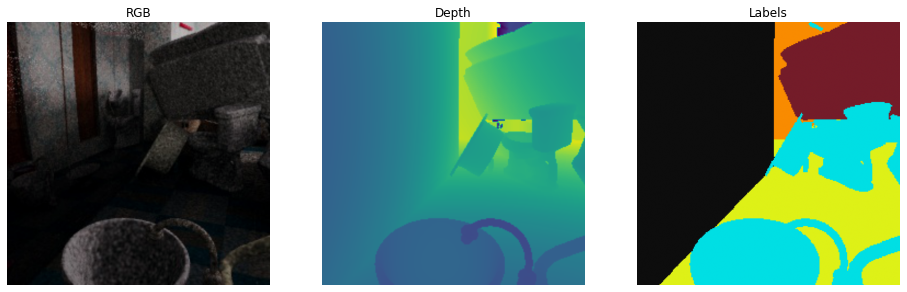

In [5]:
#Same as main method of dataloaders.datasets.coco
city_val = SceneNetSegmentation(cfg, split='val')

dataloader = DataLoader(city_val, batch_size=1, shuffle=True, num_workers=0)

for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img_tmp = city_val.loader.invert_normalization(sample['image'].squeeze())
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp, dataset='scenenet')
        
        imgs = [img_tmp[:,:,:3], img_tmp[:,:,3:].squeeze(), segmap]
        labels = ['RGB', 'Depth', 'Labels']
        display_grid(imgs, labels)

    break

plt.show(block=True)

Load a saved model and visualize results
-----

The trained model takes the RGB-D image as input and produces a segmentation mask

In [6]:
import torch
import os
from deeplab3.dataloaders import make_data_loader
from deeplab3.modeling.sync_batchnorm.replicate import patch_replication_callback
from deeplab3.modeling import load_model

In [9]:
model_dirs = [ \
                    #Bright models 
                   '../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/',
                   '../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/',
                    #Low-light models
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/']

In [17]:
from deeplab3.config.defaults import get_cfg_defaults
from deeplab3.utils import model_utils

models = []

for model_dir in model_dirs:
    cfg = model_utils.match_cfg_versions(model_dir + "parameters.yaml")
    cfg.merge_from_list(['SYSTEM.GPU_IDS', [0],
                          'CHECKPOINT.RESUME', True, 
                          'CHECKPOINT.DIRECTORY', model_dir,
                         ])
    m = load_model(cfg)
    m.eval()
    models.append({'model': m, 
                   'cfg' : cfg,
                   'label': model_dir.split('/')[3].replace('scenenet_', ''), 
                   'mode': cfg.DATASET.MODE })

Non-existent key: DATASET.CITYSCAPES.TEST_SET
Training backbone from scratch
=> loaded checkpoint '../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/checkpoint.pth.tar' (epoch 10)
Training backbone from scratch
=> loaded checkpoint '../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/checkpoint.pth.tar' (epoch 8)
Training backbone from scratch
=> loaded checkpoint '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/checkpoint.pth.tar' (epoch 4)
Training backbone from scratch
=> loaded checkpoint '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/checkpoint.pth.tar' (epoch 5)


In [18]:
def run_model(cfg, image, model):
    if cfg.SYSTEM.CUDA:
        image= image.cuda()
    with torch.no_grad():
        output = model(image)
        
    pred = output.data.cpu().numpy()
    pred = np.argmax(pred, axis=1)
    return pred
        
def display_prediction_grid(image, target, models):
    image_display = city_val.loader.invert_normalization(image.squeeze())
    segmap = decode_segmap(target.numpy().squeeze(), dataset='scenenet')
          
    images = [image_display[:, :, :3], image_display[:, :, 3:].squeeze(), segmap]
    labels = ['RGB', 'Depth', 'GT']
    
    for model in models:
        if(model['mode'] == 'RGB'):
            m_image = image[:,:3,:,:].clone()
        else:
            m_image = image.clone()
        
        pred = run_model(model['cfg'], m_image, model['model'])
        segmap = decode_segmap(pred.squeeze(), dataset='scenenet')
        
        images.extend([segmap])
        labels.extend([model['label']])

    display_grid(images, labels)

['bed', 'books', 'ceiling', 'chair', 'floor', 'furniture', 'objects', 'picture', 'sofa', 'table', 'tv', 'wall', 'window']


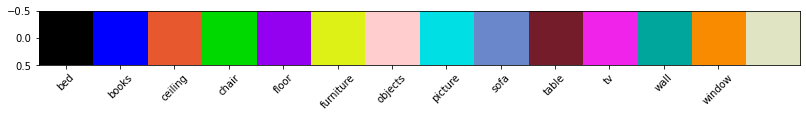

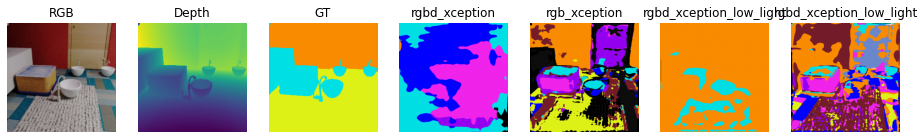

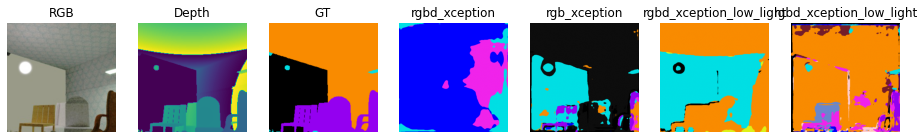

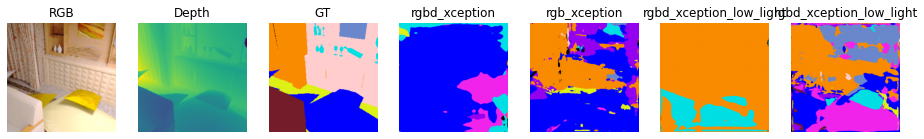

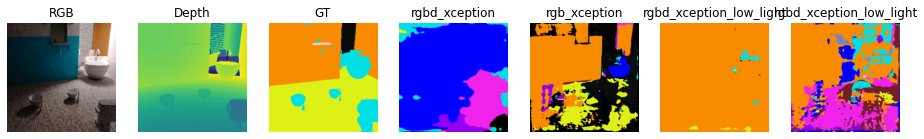

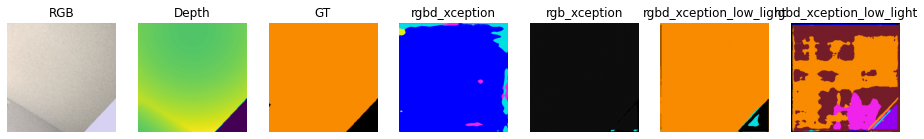

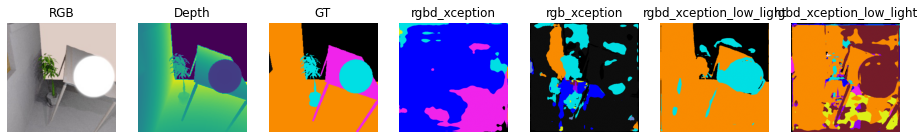

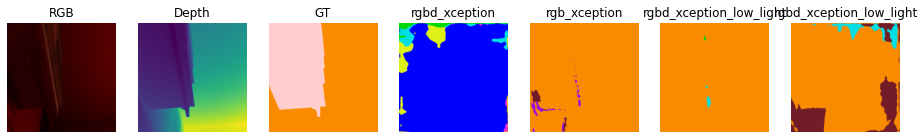

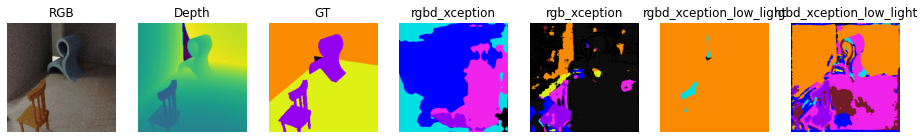

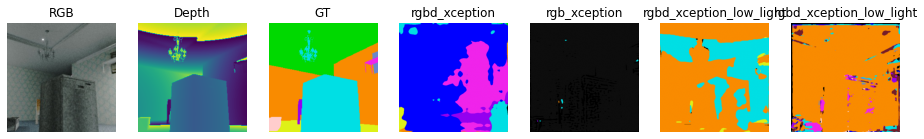

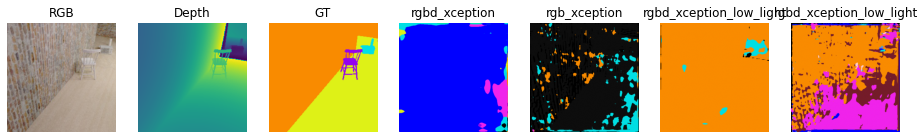

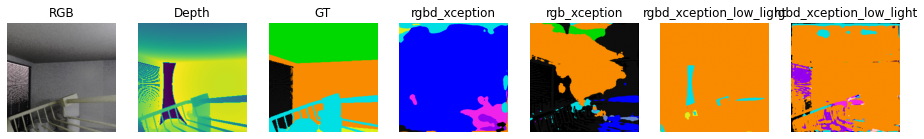

In [21]:
from deeplab3.dataloaders.utils import get_nyu13_labels

#Class colors for reference
labels = city_val.loader.class_names

plt.figure(figsize=(16, 1))
plt.imshow(np.expand_dims(get_nyu13_labels(), 0))
plt.xticks(range(len(labels)), labels, rotation=45)
print(labels)

# Test images 

for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
    display_prediction_grid(image, target, models)
    
    if ii==10:
        break

plt.show(block=True)


Convolutional Filter Visualization
--------

Code modified from https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb

In [11]:
import torch.nn as nn

def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols + 1

def plot_filters_single_channel(t, fig):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 4
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

def plot_filters_multi_channel(t, fig, num_cols=2, current_col=0):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #rows = num of kernels
    num_rows = num_kernels

    #looping through all the kernels
    for i in range(t.shape[0]):
#         if i == 0:
#             print(t[i])
        ind = sub2ind((num_rows, num_cols), i, current_col)
        ax1 = fig.add_subplot(num_rows,num_cols,ind)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        #TODO Is this normalization the correct way of visualizing? 
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        if len(t.shape) == 4:
            npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])   
    
def plot_weights(layer):
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data.cpu()
    
    #set the figure size
    num_cols = 2
    num_rows = weight_tensor.shape[0]
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    plot_filters_multi_channel(weight_tensor[:,:3, :, :], fig)
    plot_filters_multi_channel(weight_tensor[:, 3, :, :], fig, current_col=1)
        
  else:
    print("Can only visualize layers which are convolutional")                          
  
  plt.tight_layout()
  plt.show()

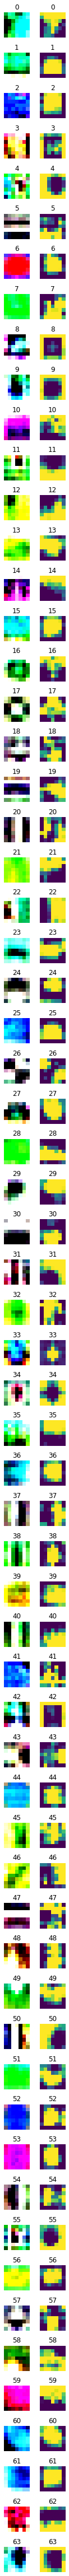

In [12]:
#visualize weights for model - first conv layer
plot_weights(rgbd_model.module.backbone.conv1)


Depth Ablation Study
-----

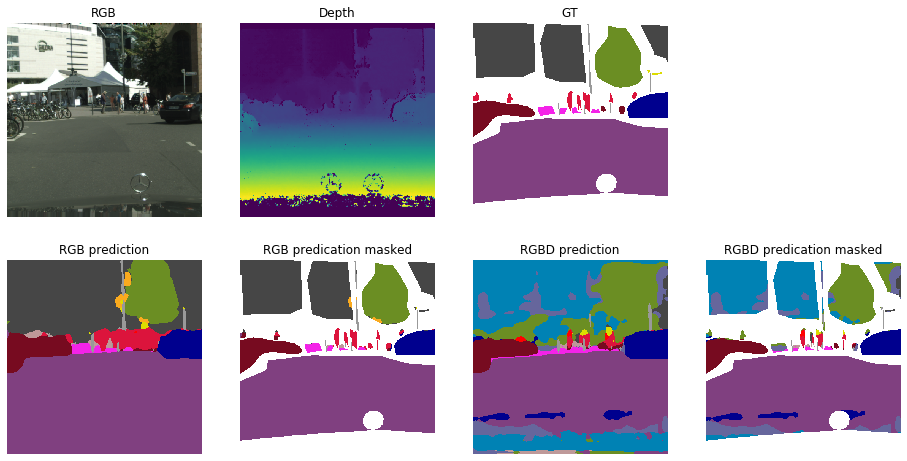

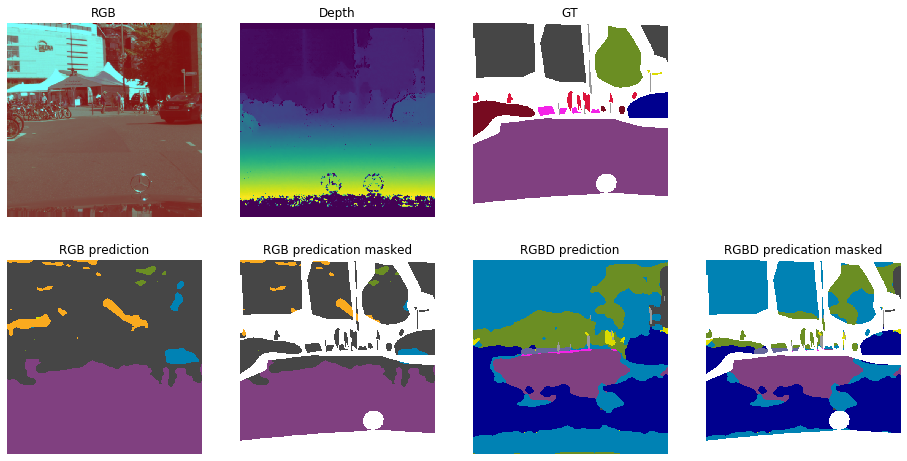

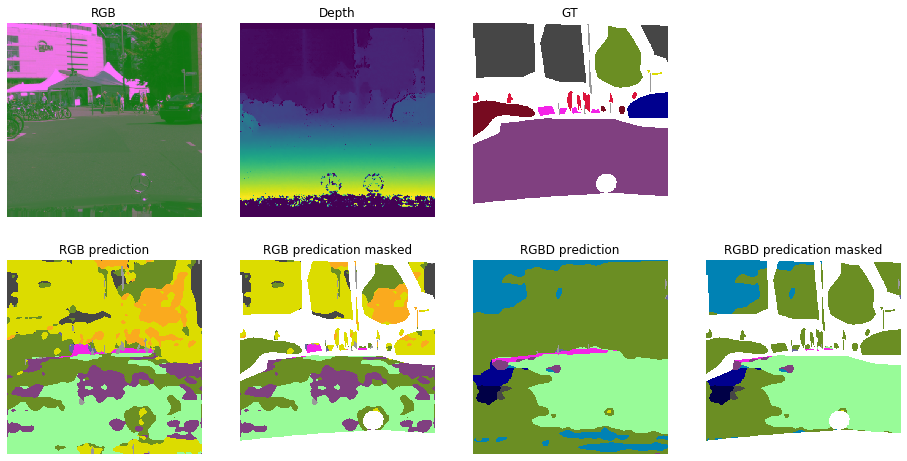

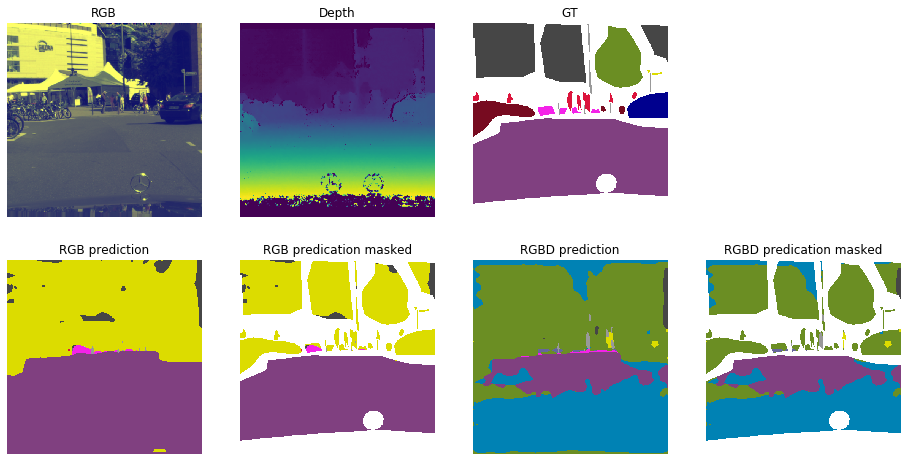

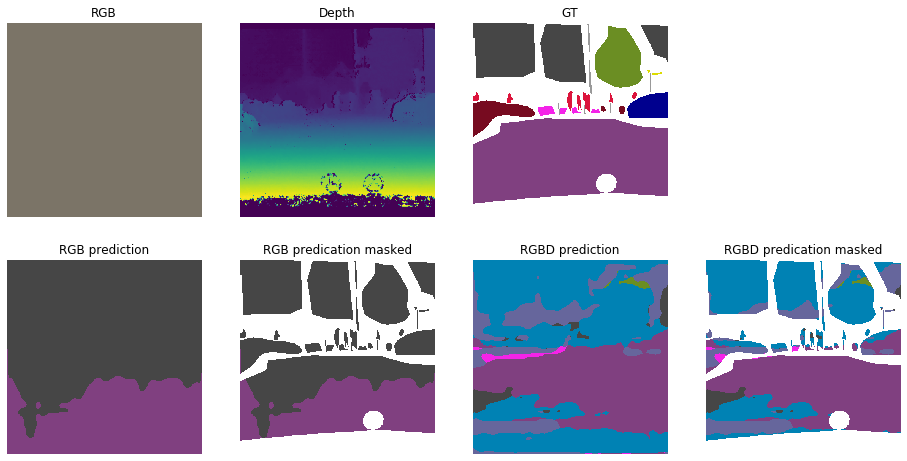

In [13]:
dataloader = DataLoader(city_val, batch_size=1, shuffle=True, num_workers=0)

for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
    display_prediction_grid(image.clone(), target)
    
    # Remove one channel
    channel_name = ['No red', 'no green', 'no blue', 'no depth']
    for jj in range(3):
        temp_image = image.clone()
        temp_image[:, jj, :, :] = 0
        display_prediction_grid(temp_image, target)
    
    # Depth only
    d_image = image.clone()
    d_image[:, 0:3, :, :] = 0
    display_prediction_grid(d_image, target)

    break

plt.show(block=True)

Loss Comparison
----


In [14]:
from deeplab3.test import Tester

test_rgbd = Tester(cfg_rgbd)
dataloader = DataLoader(city_val, batch_size=4, shuffle=True, num_workers=0)
output, mat = test_rgbd.run(dataloader, city_val.loader.NUM_CLASSES)

Training backbone from scratch


:   0%|          | 0/125 [00:00<?, ?it/s]

=> loaded checkpoint 'models/cityscapes_rgbd_3_30_c/checkpoint.pth.tar' (epoch 163)


Test loss: 0.221:   0%|          | 0/125 [00:00<?, ?it/s]/home/cc/pytorch-deeplab-xception/deeplab3/utils/metrics.py:26: RuntimeWarning: invalid value encountered in true_divide
  np.diag(confusion_matrix))
/home/cc/pytorch-deeplab-xception/deeplab3/utils/metrics.py:33: RuntimeWarning: invalid value encountered in true_divide
  np.diag(confusion_matrix))
Test loss: 0.260: 100%|██████████| 125/125 [02:03<00:00,  1.02it/s]


In [15]:
test_rgb = Tester(cfg_rgb)
dataloader = make_data_loader(cfg_rgb)[1]
output, mat = test_rgb.run(dataloader, city_val.loader.NUM_CLASSES)

Training backbone from scratch


:   0%|          | 0/63 [00:00<?, ?it/s]

=> loaded checkpoint 'models/cityscapes_rgb/checkpoint.pth.tar' (epoch 83)
Using RGB input
Found 19997 train_extra images
Using RGB input
Found 500 val images
Using RGB input
Found 1525 test images


Test loss: 0.014: 100%|██████████| 63/63 [01:21<00:00,  1.30s/it]


RGBD: {'m_iou': 0.8750763623348088, 'accuracy': 0.997214432604225, 'fw_iou': 0.9947849138547149}
RGB: {'m_iou': 0.854461400037317, 'accuracy': 0.9946282794291768, 'fw_iou': 0.9903394624642923}


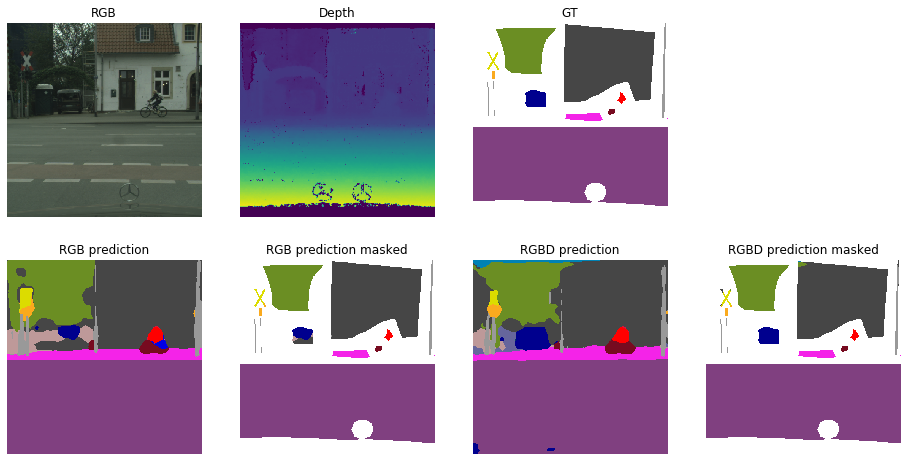

RGBD: {'m_iou': 0.7699136173846, 'accuracy': 0.9563223912463304, 'fw_iou': 0.9306901979359772}
RGB: {'m_iou': 0.9010524055645798, 'accuracy': 0.9721377101681346, 'fw_iou': 0.947434984156569}


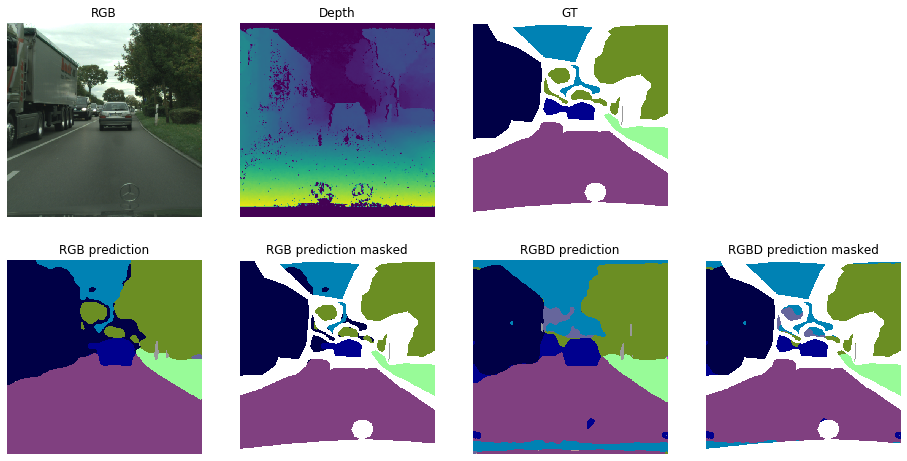

RGBD: {'m_iou': 0.43273242932275036, 'accuracy': 0.9443988301269152, 'fw_iou': 0.9007742103058193}
RGB: {'m_iou': 0.8179133668620514, 'accuracy': 0.9983954493010276, 'fw_iou': 0.9967979145956647}


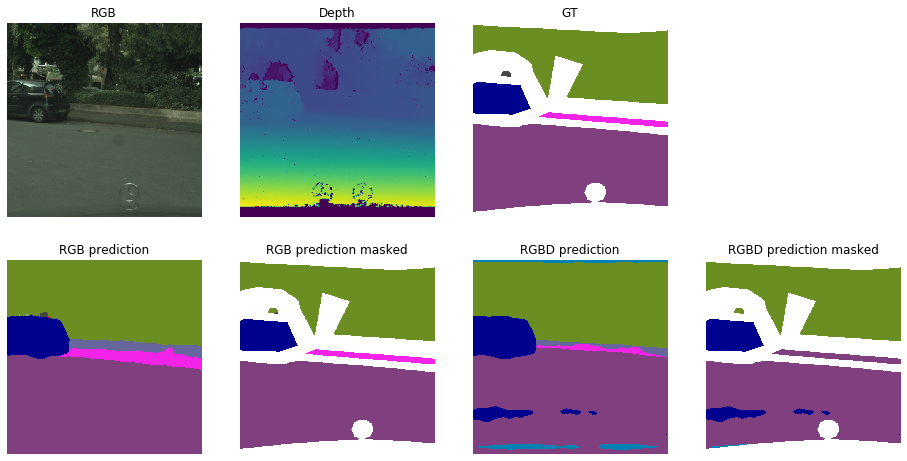

RGBD: {'m_iou': 0.38877585517652163, 'accuracy': 0.94373357579252, 'fw_iou': 0.9026910436314628}
RGB: {'m_iou': 0.6464602446245192, 'accuracy': 0.9887178861698471, 'fw_iou': 0.9793023055185347}


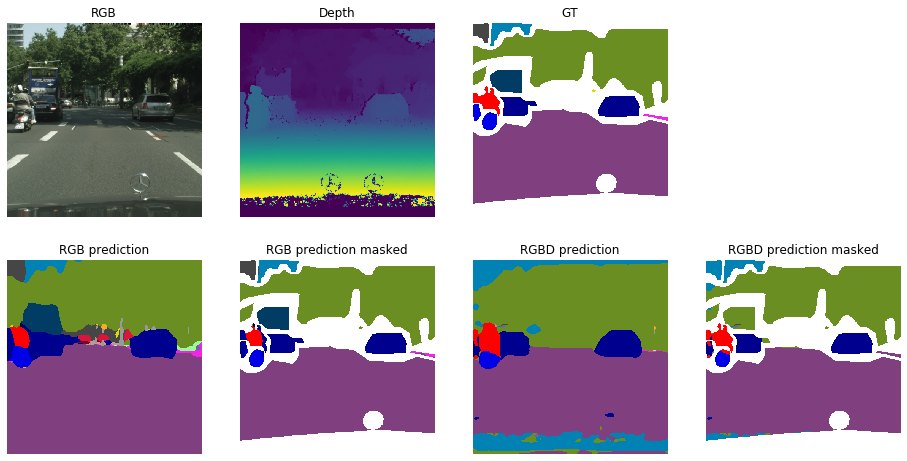

RGBD: {'m_iou': 0.5271130529446262, 'accuracy': 0.9389248470671803, 'fw_iou': 0.9025702910485736}
RGB: {'m_iou': 0.8096433339745404, 'accuracy': 0.9731793493236665, 'fw_iou': 0.9696823455276226}


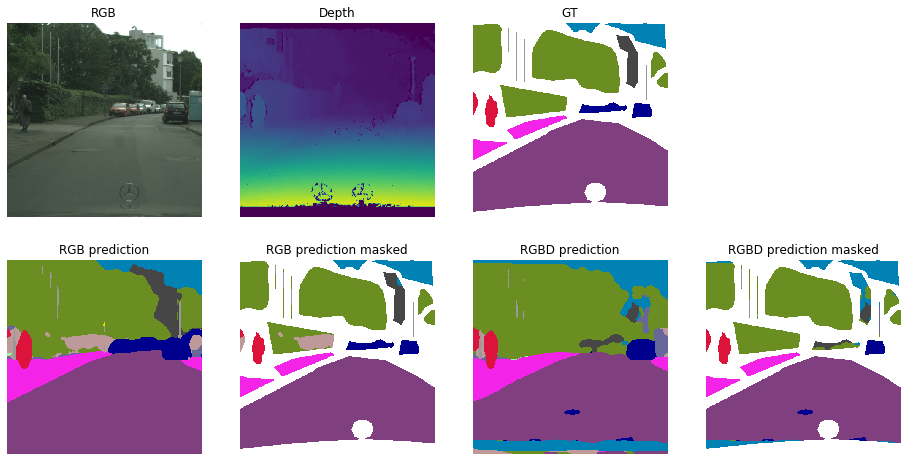

RGBD: {'m_iou': 0.633417664892096, 'accuracy': 0.9374796711671779, 'fw_iou': 0.9188647066821874}
RGB: {'m_iou': 0.8273337866560508, 'accuracy': 0.9936924813612505, 'fw_iou': 0.9892569293355209}


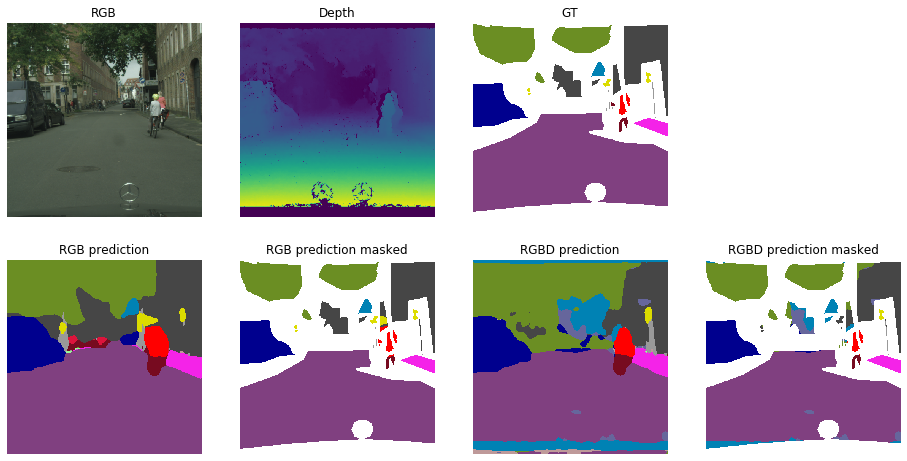

RGBD: {'m_iou': 0.45484164457105336, 'accuracy': 0.9373685556169535, 'fw_iou': 0.9135453746629041}
RGB: {'m_iou': 0.5671115527641785, 'accuracy': 0.9804864370015423, 'fw_iou': 0.9683971351971661}


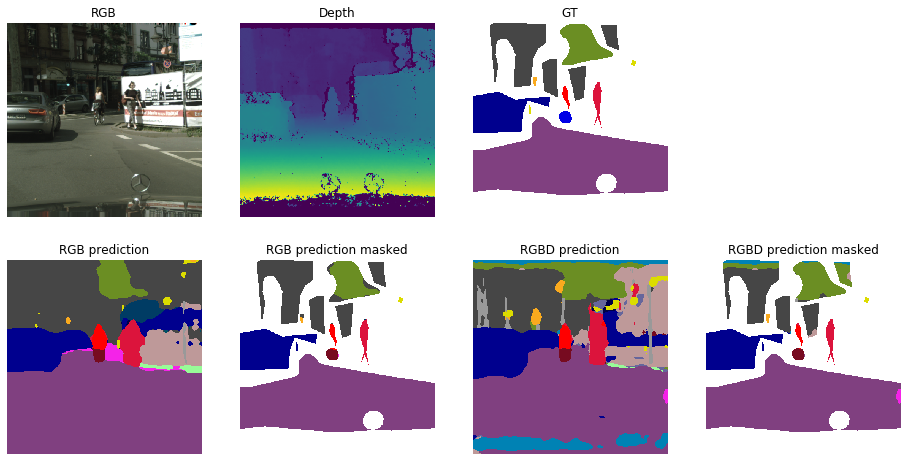

RGBD: {'m_iou': 0.38016699854769903, 'accuracy': 0.9322546675277376, 'fw_iou': 0.9298366435378038}
RGB: {'m_iou': 0.7190753683287384, 'accuracy': 0.9948044845501778, 'fw_iou': 0.9906287312182764}


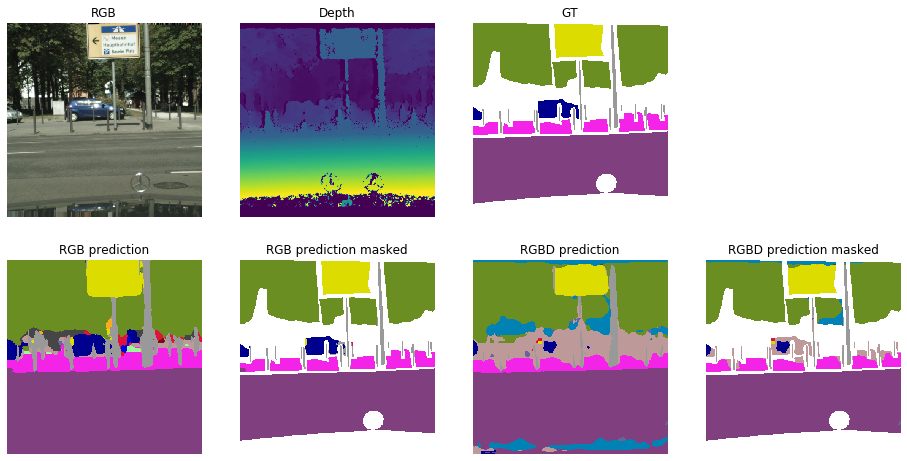

RGBD: {'m_iou': 0.42268604687813827, 'accuracy': 0.9303020020359688, 'fw_iou': 0.9002967237181344}
RGB: {'m_iou': 0.6662694213334582, 'accuracy': 0.992070162616481, 'fw_iou': 0.9876171928869607}


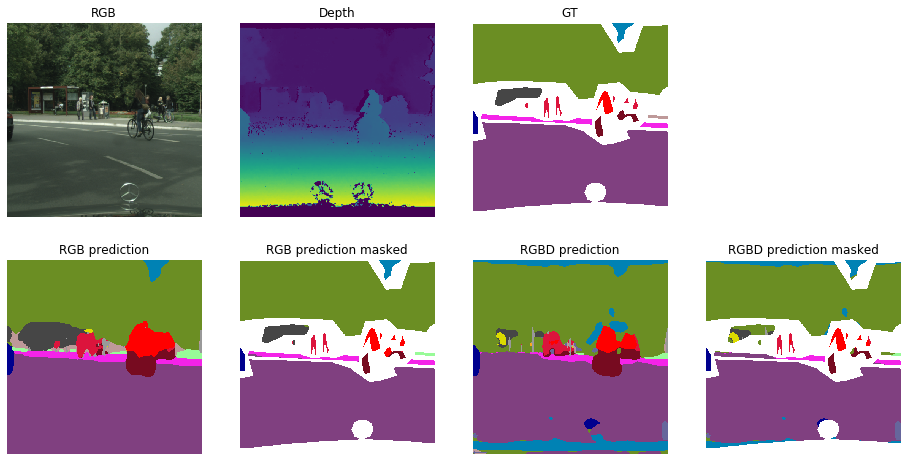

RGBD: {'m_iou': 0.5016156542769573, 'accuracy': 0.9245193874226132, 'fw_iou': 0.8690090780178737}
RGB: {'m_iou': 0.8182915988978444, 'accuracy': 0.9953513630932985, 'fw_iou': 0.990952817060744}


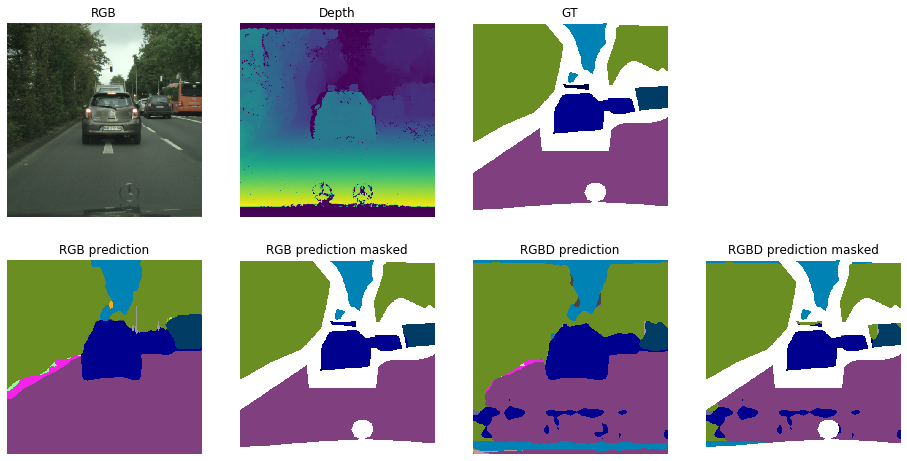

In [18]:
top = test_rgbd.img_evaluator.top_n()

for accuracy, img_list in top['accuracy'].items():
    for img_path in img_list:
        lbl_path = os.path.join(city_val.annotations_base,
                                    img_path.split(os.sep)[-2],
                                    os.path.basename(img_path)[:-15] + '{}_labelIds.png'.format(city_val.cfg.DATASET.CITYSCAPES.GT_MODE))

        depth_path = os.path.join(city_val.depth_base,
                                    img_path.split(os.sep)[-2],
                                    os.path.basename(img_path)[:-15] + '{}.png'.format(city_val.cfg.DATASET.CITYSCAPES.DEPTH_DIR))

        sample = city_val.loader.load_sample(img_path, depth_path, lbl_path)

        image, target = sample['image'].unsqueeze(0), sample['label'].unsqueeze(0)
        print('RGBD: {}'.format(test_rgbd.img_evaluator.image_stats[img_path]))
        print('RGB: {}'.format(test_rgb.img_evaluator.image_stats[img_path]))
        display_prediction_grid(image, target)
        plt.show()